# 📘 Notebook Purpose and Summary

This notebook processes multiple radio instrument data files with the goal of **removing background noise** (`BG_EIRP`) from measured signal power (`EIRP`) and preparing the data for further analysis (e.g., detrending or spectral analysis).

---

## 🎯 Purpose

- Load multiple instrument measurement files (in CSV format)
- Clean missing data **independently for each file**
- Subtract the background signal in **logarithmic space** (EIRP - BG_EIRP)
- Plot background-corrected signals vs frequency
- Prepare for further filtering or detrending (e.g., using Savitzky-Golay or polynomial fitting)

---

## 🔢 Input

- Multiple `.csv` files stored in the same folder
- Each file represents data from a different instrument
- Required columns in each file:
  - `frequency` (Hz) — shared across all instruments
  - `EIRP` (dBm) — measured signal
  - `BG_EIRP` (dBm) — estimated background

---

## ⚙️ Logic and Algorithm

1. **Load all `.csv` files** using `glob`.
2. **Independently clean each file** by applying `.dropna()`.
3. **Background subtraction in logarithmic domain**:
   - Convert EIRP and BG_EIRP from dBm to linear scale (mW):
     \[
     P_{\text{mW}} = 10^{\frac{P_{\text{dBm}}}{10}}
     \]
   - Subtract background:
     \[
     \text{Signal}_{\text{mW}} = EIRP_{\text{mW}} - BG_{\text{mW}}
     \]
   - Convert the result back to dBm:
     \[
     \text{Signal}_{\text{dBm}} = 10 \cdot \log_{10}(\text{Signal}_{\text{mW}})
     \]
4. **Plot** the corrected signals for each instrument as a function of frequency.

---

## 📤 Output

- Cleaned and corrected signals plotted for comparison.
- Each instrument's data is processed and visualized independently.
- Ready for next steps: filtering, detrending, or spectral analysis.

---

## 📌 Notes

- This notebook is part of a broader workflow:
  - Separate notebooks will handle:
    - Detrending using polynomial or Savitzky-Golay filters
    - Model selection (e.g., using Bayesian Information Criterion)


In [25]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from scipy.stats import skew, kurtosis
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks, savgol_filter 
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import mean_squared_error



from astropy.stats import median_absolute_deviation as MAD


In [26]:
# #plots layout
from matplotlib import rc
# from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.font_manager
import matplotlib.colors as colors


plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 18


SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 19

plt.rc('font', size=SMALL_SIZE)          # controls default text
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


In [27]:
folder = "Data/Additional_EIRPs"  # path for folder
files = glob.glob(os.path.join(folder, "*.csv"))

# Dictionary to store each instrument's data
data = {}

for file in files:
    # Get file base name without extension (e.g., camera, radio)
    label = os.path.splitext(os.path.basename(file))[0]
    
    # Load CSV into a DataFrame
    df = pd.read_csv(file)
    
    # Store in the dictionary
    data[label] = df

In [28]:
temp_df = data['Kiricom_Radio_On_MAX_100kHz_EIRP']
temp_df.columns

Index(['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)'], dtype='object')

In [29]:
for instrument_name, df in data.items():
    print(f"\nColumns in {instrument_name}:")
    print(df.columns.tolist())


Columns in Kiricom_Radio_On_MAX_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']

Columns in Superfire_HL58_Headlamp_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']

Columns in ALS_Bakkie_CAA567123_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']

Columns in 2020_02_11_INCA_Camera_100kHz_EIRP:
['Frequency(MHz)', 'EIRP(dBm)', 'BG_EIRP(dBm)']


/tmp/ipykernel_3935/2337824273.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


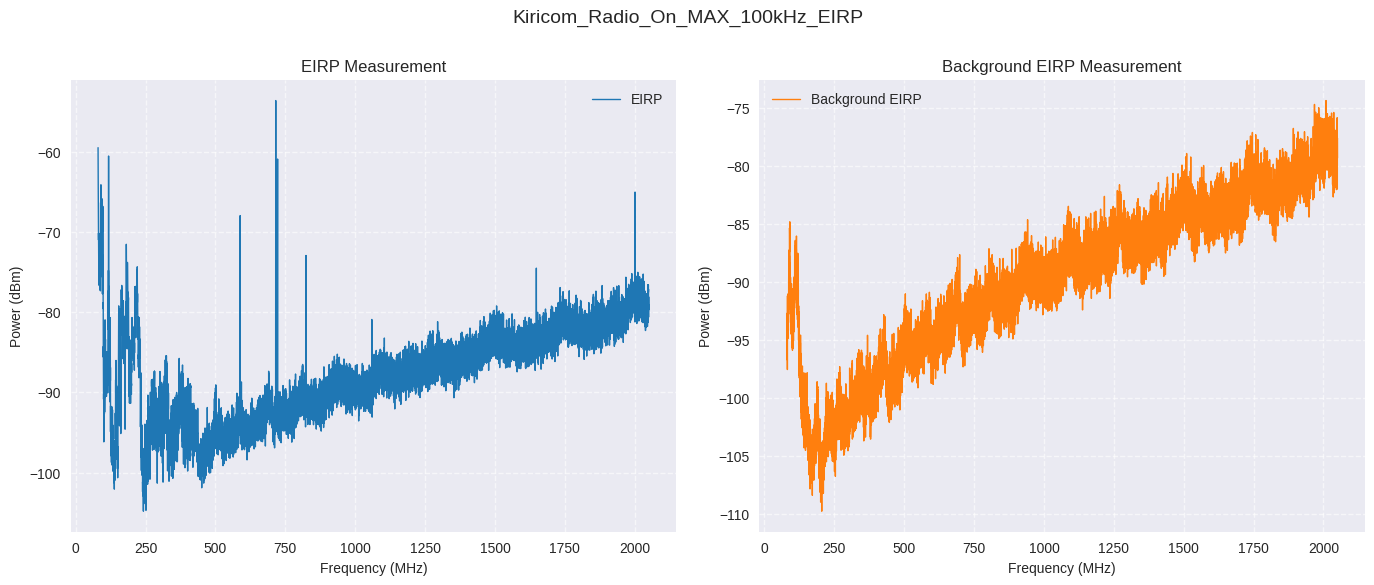

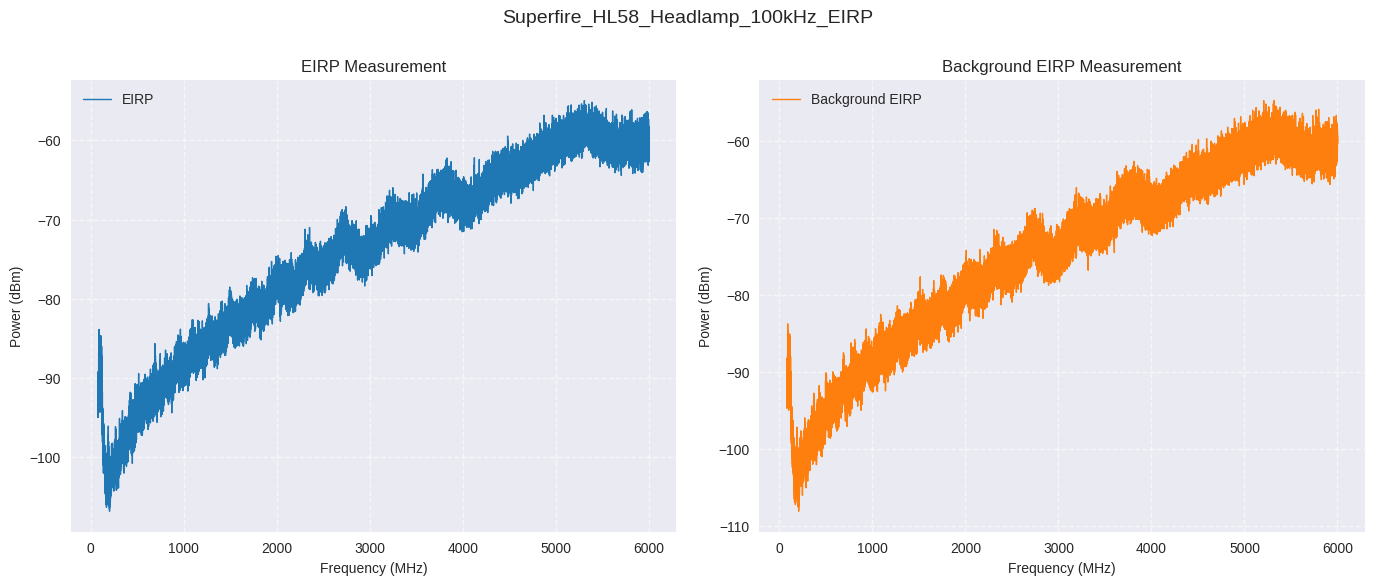

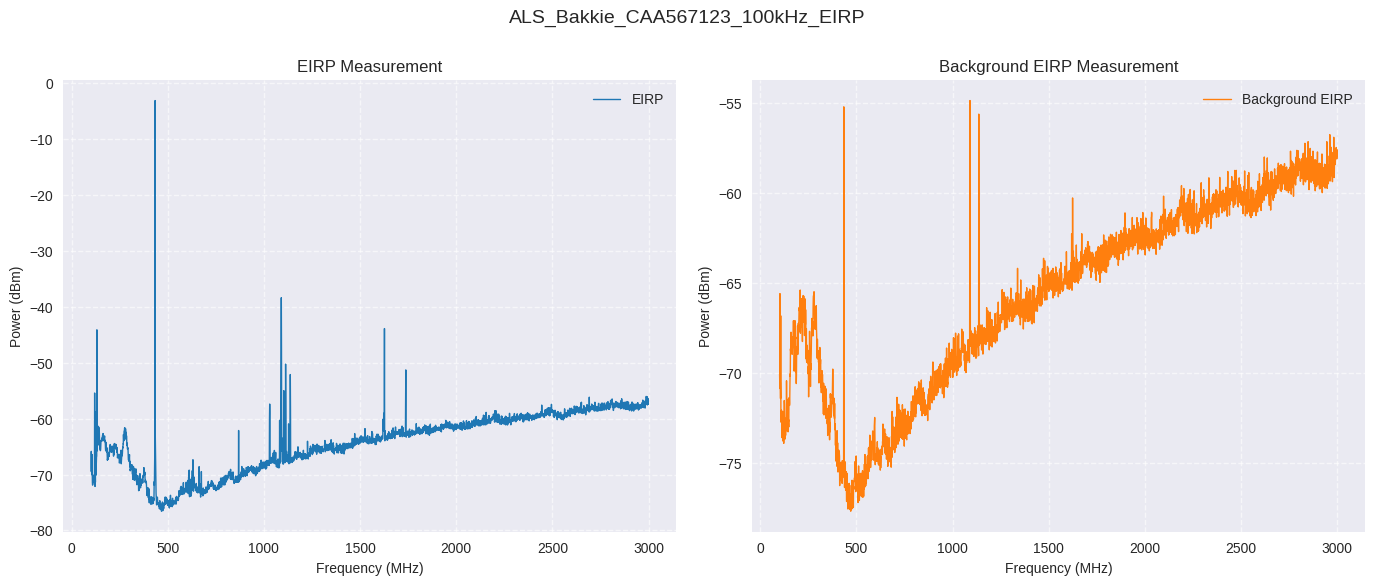

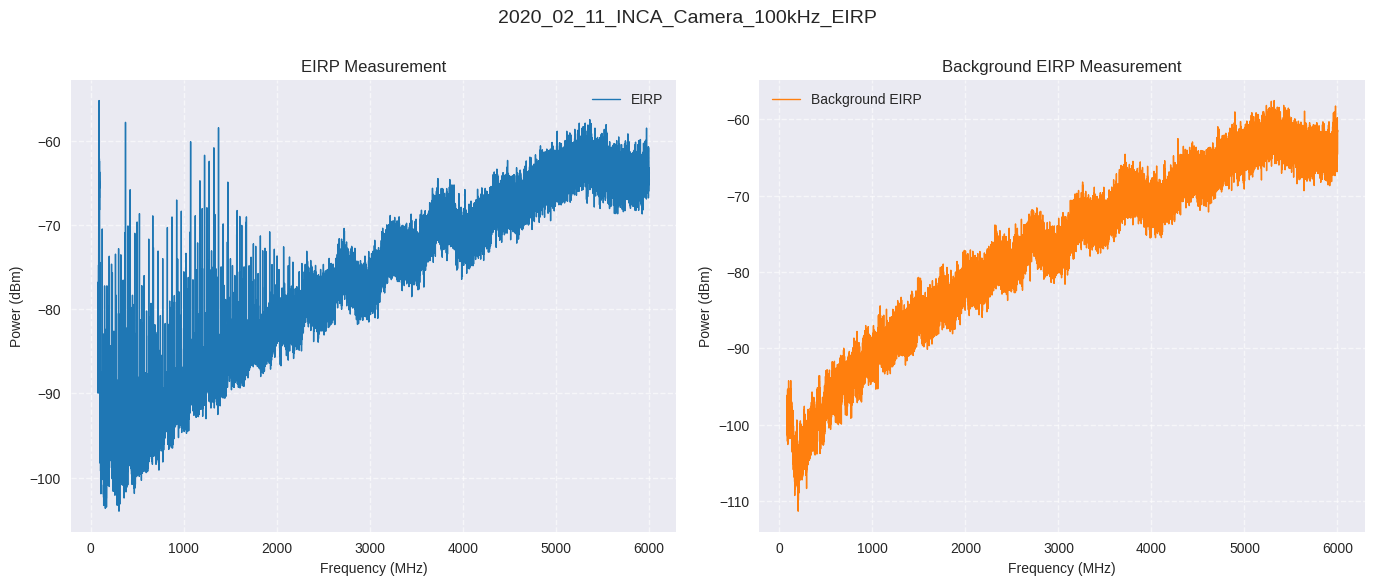

In [30]:
# Set style for better visual appearance
plt.style.use('seaborn')

for instrument_name, data_plot in data.items():
    # Create figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{instrument_name}', fontsize=14)
    
    # Plot EIRP data
    axs[0].plot(data_plot['Frequency(MHz)'], data_plot['EIRP(dBm)'], 
               color='tab:blue', linewidth=1, label='EIRP')
    axs[0].set_xlabel('Frequency (MHz)', fontsize=10)
    axs[0].set_ylabel('Power (dBm)', fontsize=10)
    axs[0].set_title('EIRP Measurement', fontsize=12)
    axs[0].grid(True, linestyle='--', alpha=0.6)
    axs[0].legend()
    
    # Plot Background EIRP data
    axs[1].plot(data_plot['Frequency(MHz)'], data_plot['BG_EIRP(dBm)'], 
               color='tab:orange', linewidth=1, label='Background EIRP')
    axs[1].set_xlabel('Frequency (MHz)', fontsize=10)
    axs[1].set_ylabel('Power (dBm)', fontsize=10)
    axs[1].set_title('Background EIRP Measurement', fontsize=12)
    axs[1].grid(True, linestyle='--', alpha=0.6)
    axs[1].legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Remove the back groud signal 

To remove the back-group noite:
1. convert the measurements form (dBm) to mW, i.e, from log-scale for liner scale.
2. perfome the substraction of the back-groud 
3. convert back to log scale

In [31]:
def bg_remove(signal, background):
     """
    Args:
    signal: mesurements of the instrument + noise
    background: mesurement of the background

    Return:
    clean_signal: signal of the instrument
    """
     
    # convert log scale to linear scale
     signal_mW = 10**(signal/10)
     background_mW = 10**(background/10)

    # Subtract background in linear scale
     clean_mW = signal_mW - background_mW
     clean_mW[clean_mW <= 0] = np.nan

    # Convert back to dBm
     clean_signal = 10 * np.log10(clean_mW)
     
     print(type(clean_signal))

     return clean_signal



In [32]:
!pwd

/home/garces/Desktop/Master


<class 'pandas.core.series.Series'>


/tmp/ipykernel_3935/4151474761.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


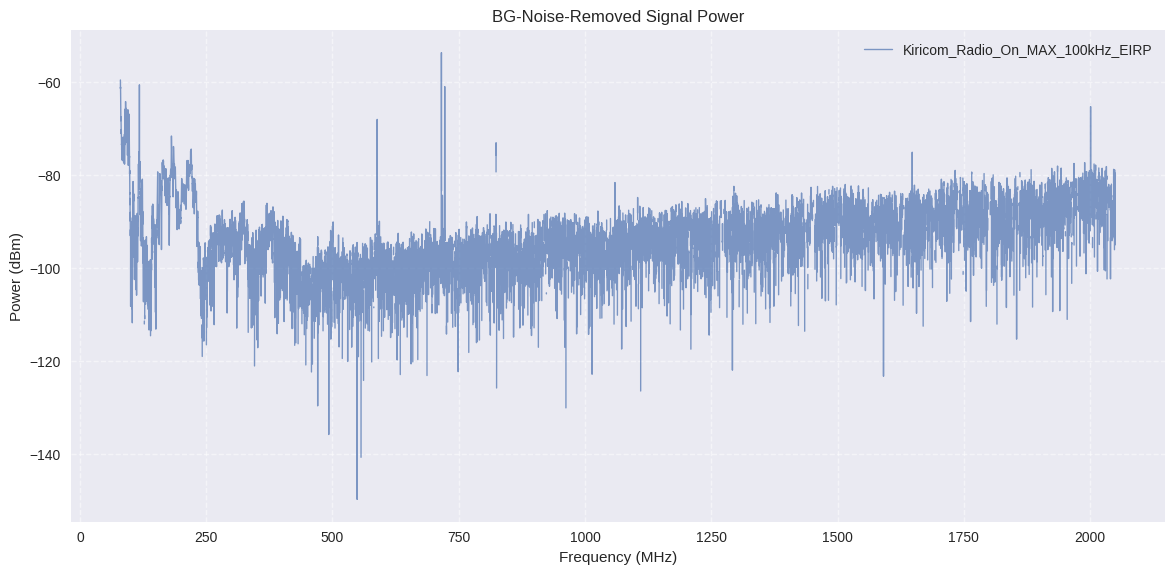

/tmp/ipykernel_3935/4151474761.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


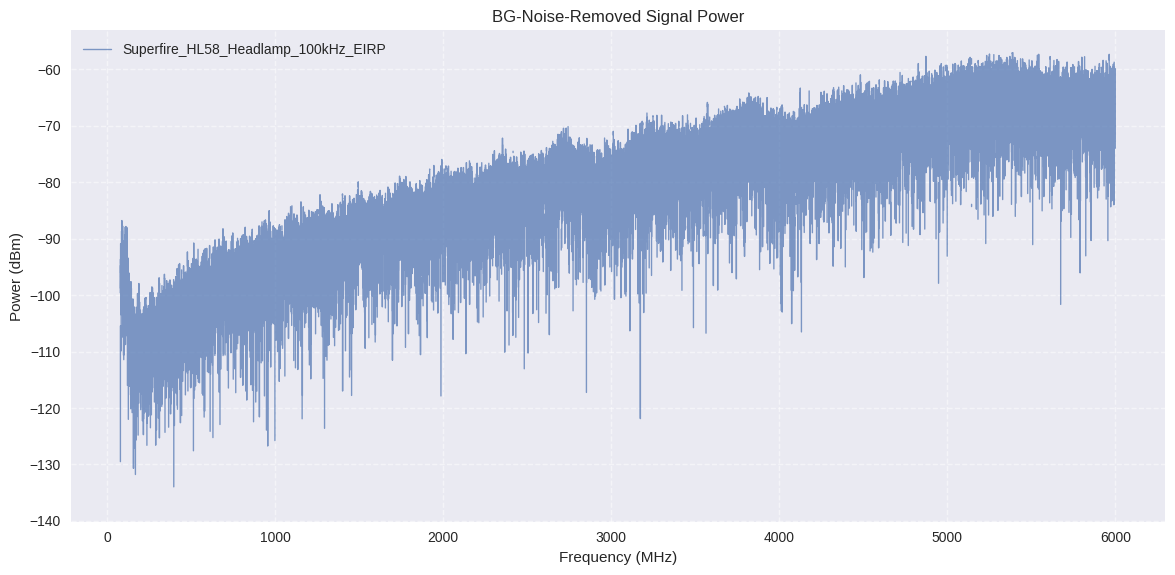

/tmp/ipykernel_3935/4151474761.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


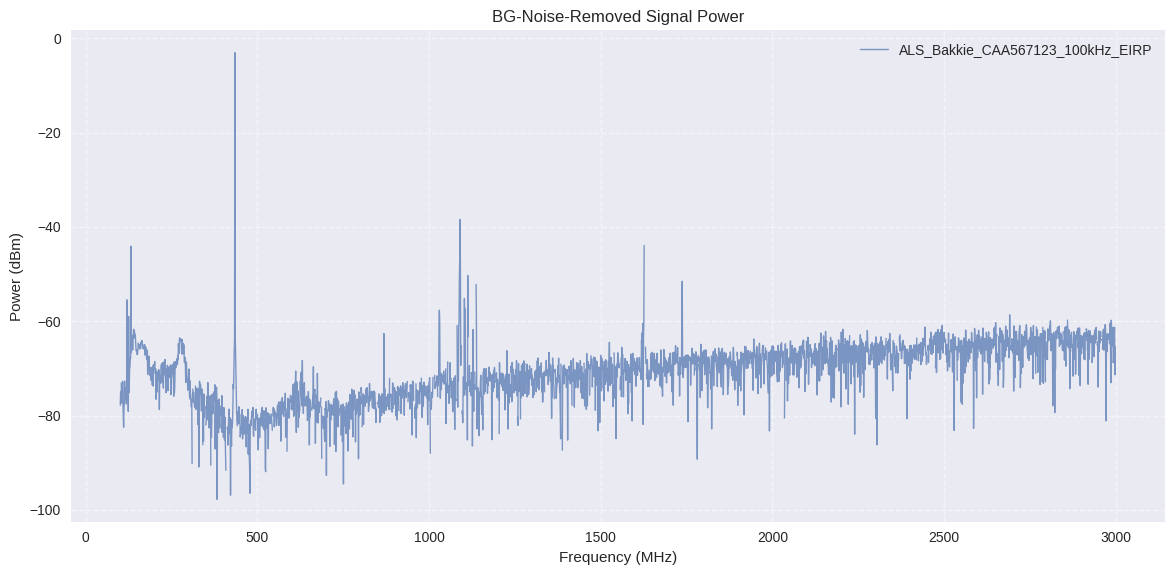

/tmp/ipykernel_3935/4151474761.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.series.Series'>


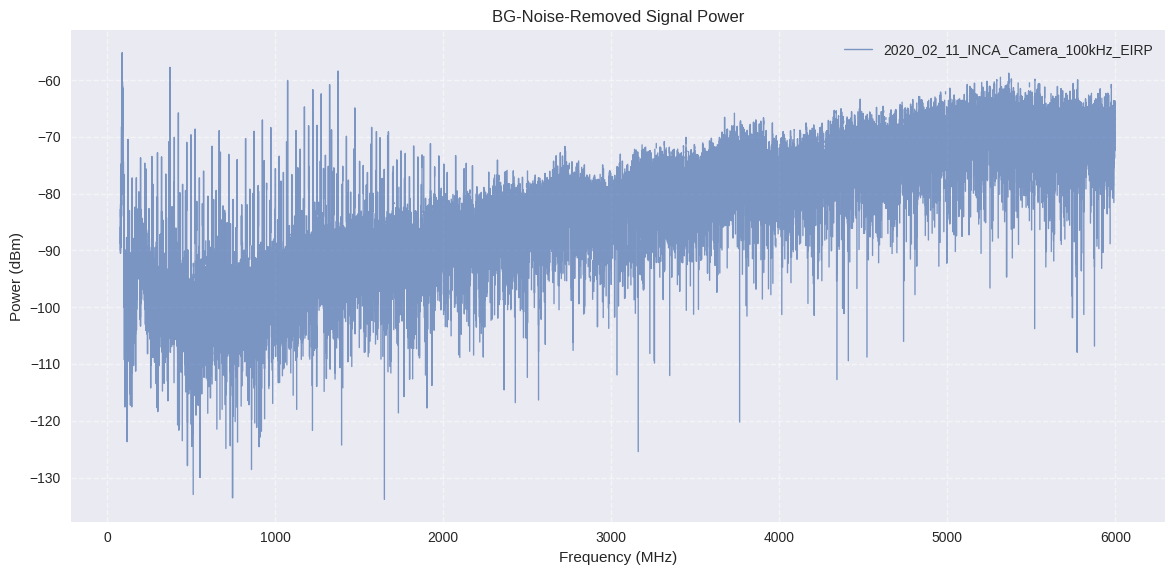

In [33]:


for instrument_name, df in data.items():
    # Plot settings
    plt.style.use('seaborn')
    plt.figure(figsize=(12, 6))


    clean_signal = bg_remove(df['EIRP(dBm)'], df['BG_EIRP(dBm)'])

    # # save to a dataframe
    # clean_instrument = {'Frequency (MHz)': df['Frequency(MHz)'],
    #               'Clean_EIRP(dBm)': clean_signal}
    # dataframe = pd.DataFrame(clean_instrument)
    # dataframe.to_csv(f'Data/Data_cleaned/{instrument_name}.csv')
    
    

    # Plot with proper labels
    plt.plot(df['Frequency(MHz)'], clean_signal, 
             label=instrument_name, 
             alpha=0.7,
             linewidth=1)
    

    # Format plot
    plt.title('BG-Noise-Removed Signal Power')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Power (dBm)')
    #plt.xlim(50,350)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Read all clean data

In [34]:
folder = "Data/Data_cleaned"  # path for folder
files = glob.glob(os.path.join(folder, "*.csv"))

# Dictionary to store each instrument's data
dataframe_clean = {}
labels = []

for file in files:
    # Get file base name without extension (e.g., camera, radio)
    label = os.path.splitext(os.path.basename(file))[0]
    labels.append(label)

    
    # Load CSV into a DataFrame
    df = pd.read_csv(file)
    
    #drop any row with missing values in this file only
    df = df.dropna().reset_index(drop=True)


    # # Store in the dictionary
    dataframe_clean[label] = df

dataframe_clean

{'Kiricom_Radio_On_MAX_100kHz_EIRP':        Unnamed: 0  Frequency (MHz)  Clean_EIRP(dBm)
 0               0          80.0925       -59.478259
 1               1          80.1850       -61.157473
 2               2          80.2775       -61.318212
 3               3          80.3700       -60.994273
 4               4          80.4625       -61.422765
 ...           ...              ...              ...
 12797       21291        2049.5100       -87.196076
 12798       21292        2049.6025       -84.371832
 12799       21294        2049.7875       -86.330525
 12800       21295        2049.8800       -94.942077
 12801       21296        2049.9725       -92.431921
 
 [12802 rows x 3 columns],
 'Superfire_HL58_Headlamp_100kHz_EIRP':        Unnamed: 0  Frequency (MHz)  Clean_EIRP(dBm)
 0               1          80.0925      -105.448569
 1               2          80.1850      -129.491156
 2               5          80.4625       -98.770357
 3               6          80.5550       -93.65

/tmp/ipykernel_3935/534382732.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


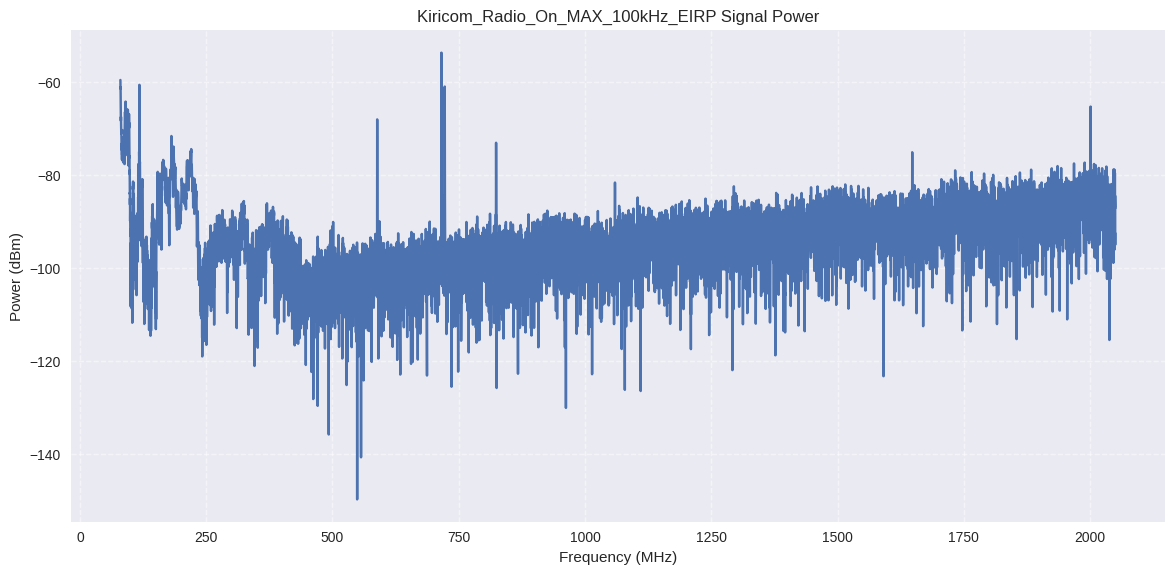

/tmp/ipykernel_3935/534382732.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


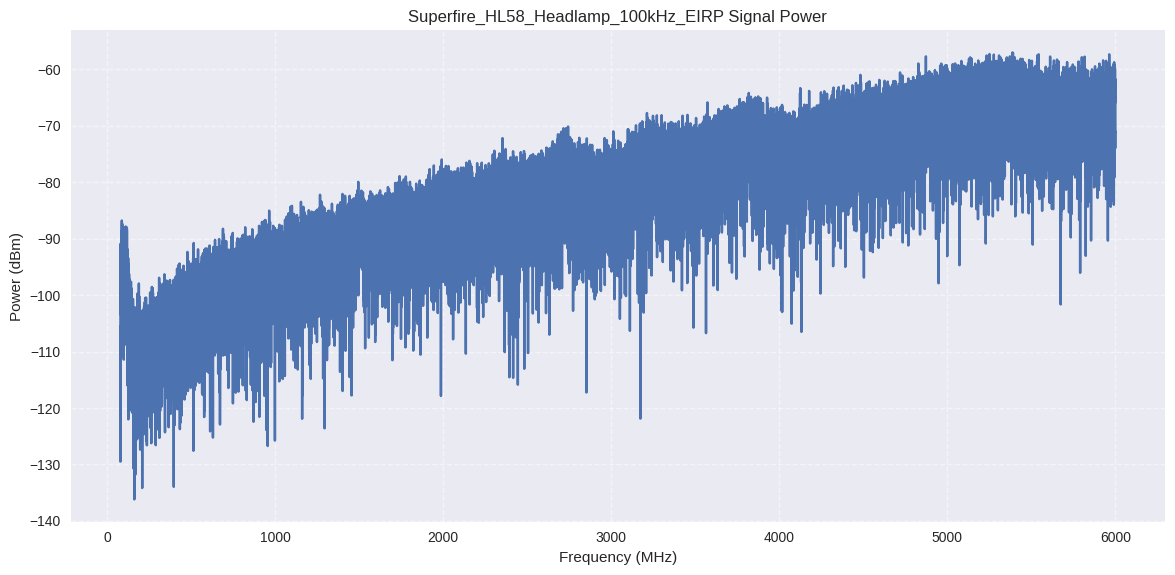

/tmp/ipykernel_3935/534382732.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


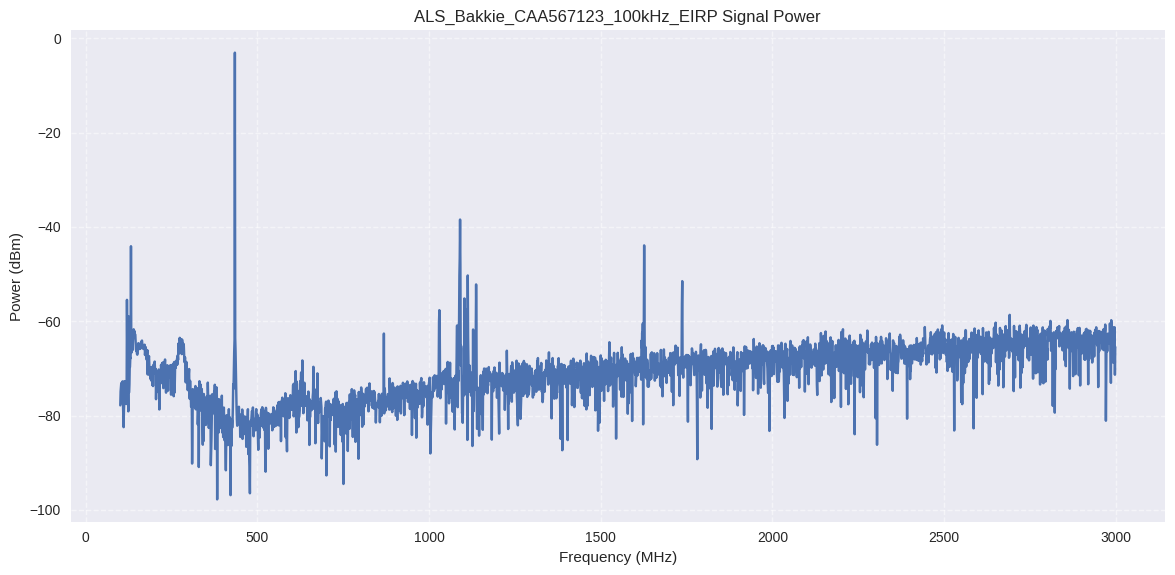

/tmp/ipykernel_3935/534382732.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


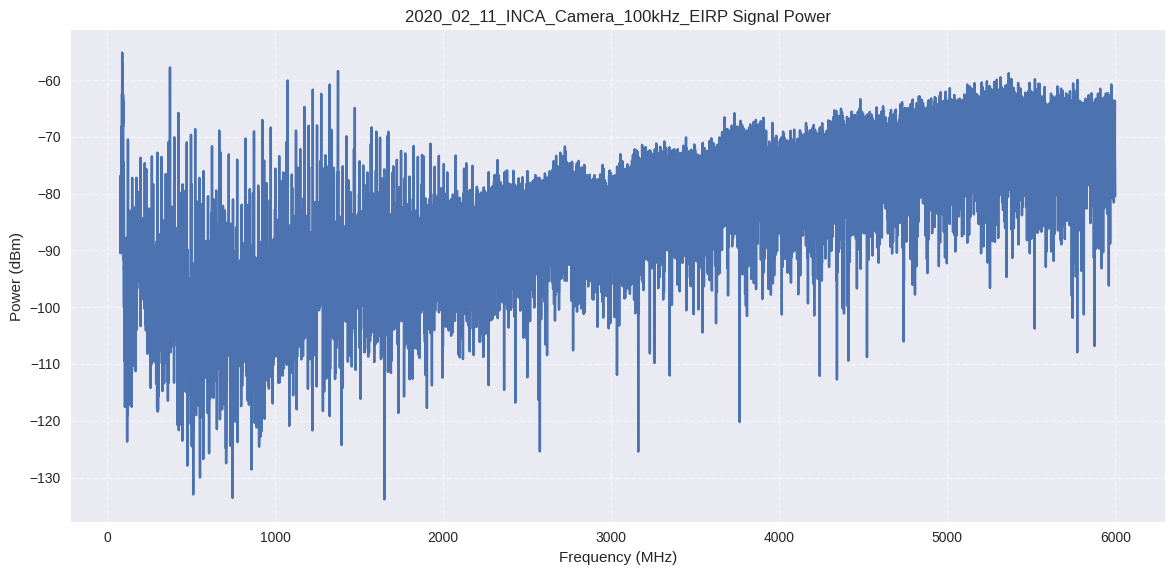

In [35]:

for instrument_name, df in dataframe_clean.items():
    # Plot settings
    plt.style.use('seaborn')
    plt.figure(figsize=(12, 6))

    
    

    # Plot the instrument PSD
    plt.plot(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'])
    

    plt.title(f'{instrument_name} Signal Power')
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Power (dBm)')
    #plt.xlim(50,350)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Determine the best polynomial order for the data

--> To determine the best polynomial order for fitting data (e.g., for detrending), use the Bayesian Information Criterion (BIC) — a standard method for model selection that balances fit quality with model complexity.

In [36]:

def calculate_bic(frequencies, signal, max_degree):
    """
    Calculate BIC values for polynomial fits of varying degrees
    
    Parameters:
    - frequencies: array-like, input frequency values
    - signal: array-like, signal power values
    - max_degree: int, maximum polynomial degree to test 
    
    Returns:
    - bics: list of BIC values for degrees 1..max_degree
    - optimal_degree: degree with minimum BIC
    """
    
    degrees = range(1, max_degree + 1)
    bics = []
    n = len(frequencies)
    
    for deg in degrees:
        # Fit polynomial
        coeffs = np.polyfit(frequencies, signal, deg)
        y_fit = np.polyval(coeffs, frequencies)
        
        # Residual sum of squares
        residuals = signal - y_fit
        rss = np.sum(residuals ** 2)
        
        # BIC calculation
        k = deg + 1  # Number of parameters
        bic = n * np.log(rss / n) + k * np.log(n)
        bics.append(bic)
    
    
    return bics, degrees

/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/86

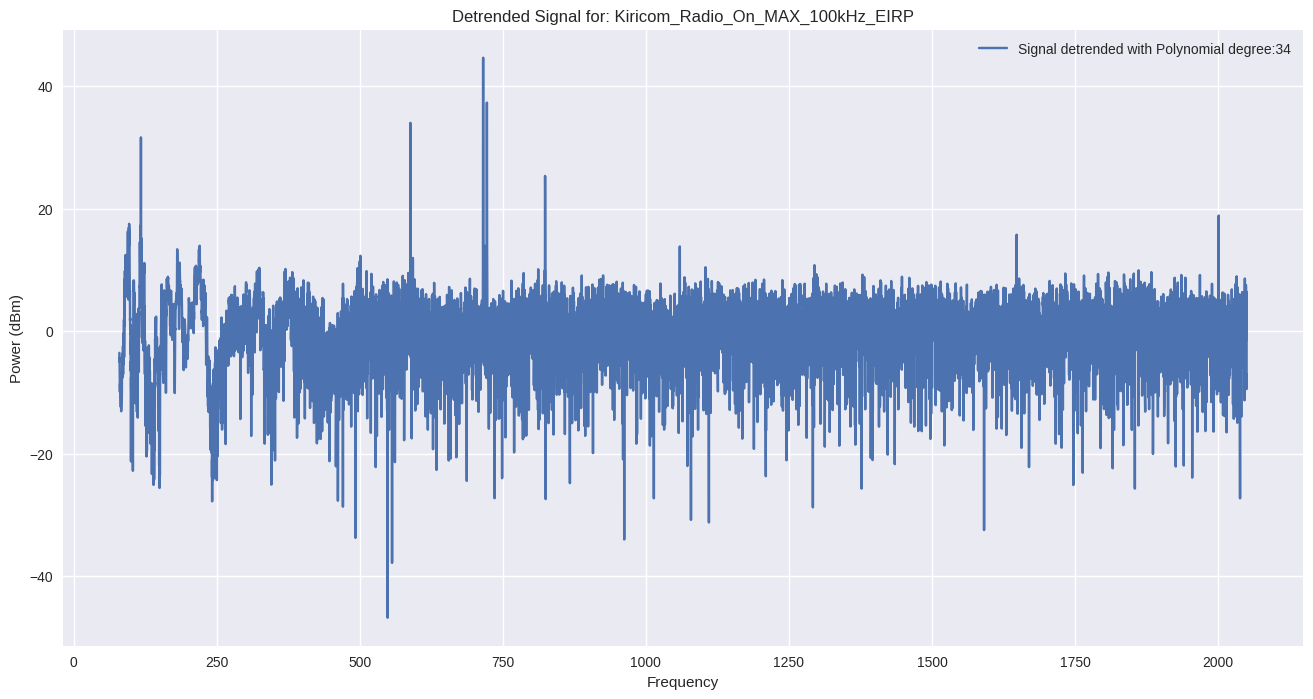

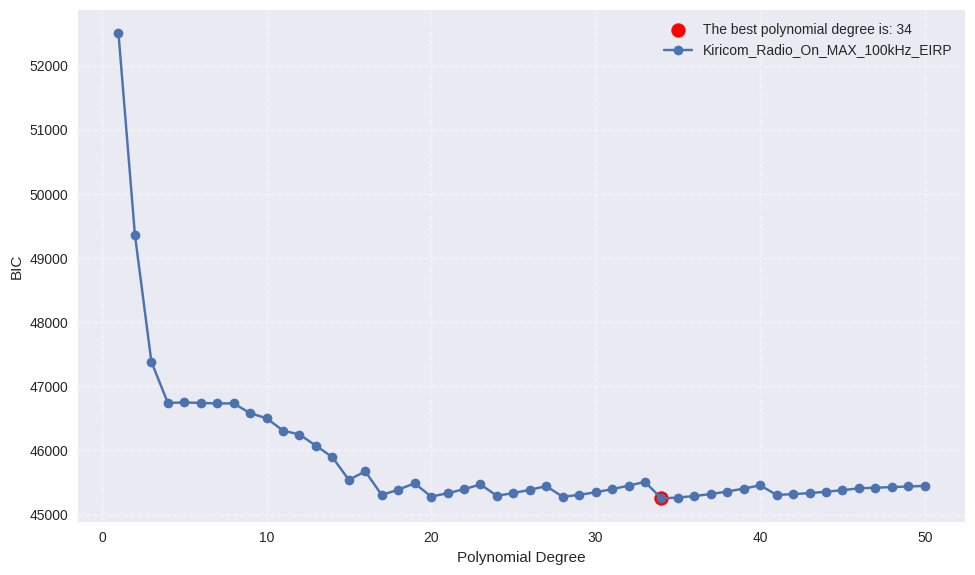

/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/86

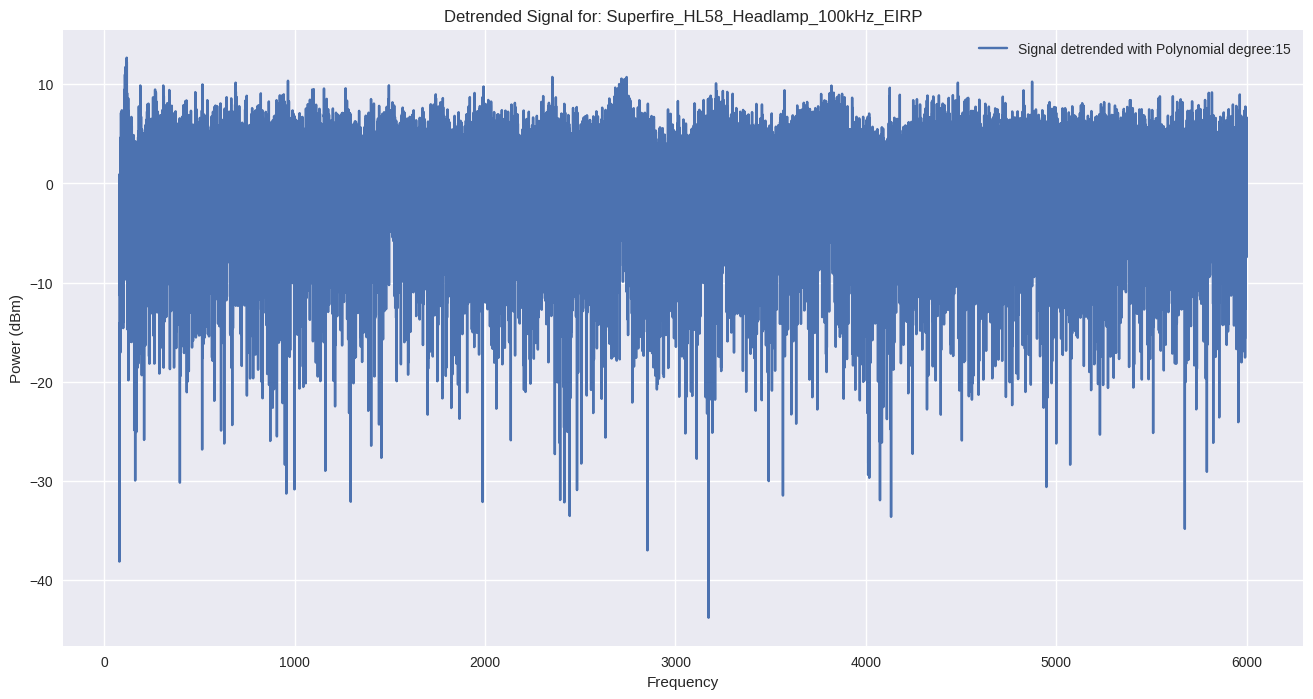

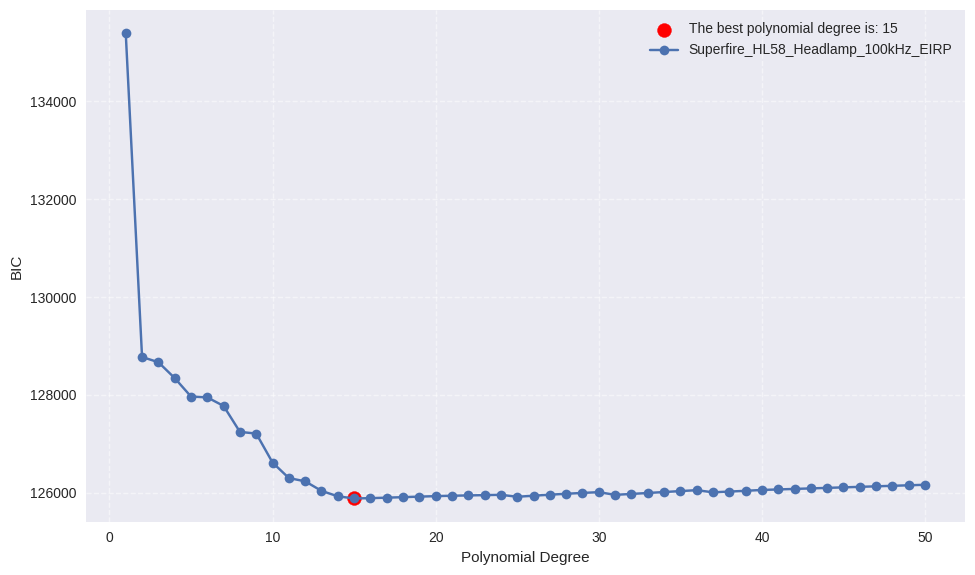

/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/86

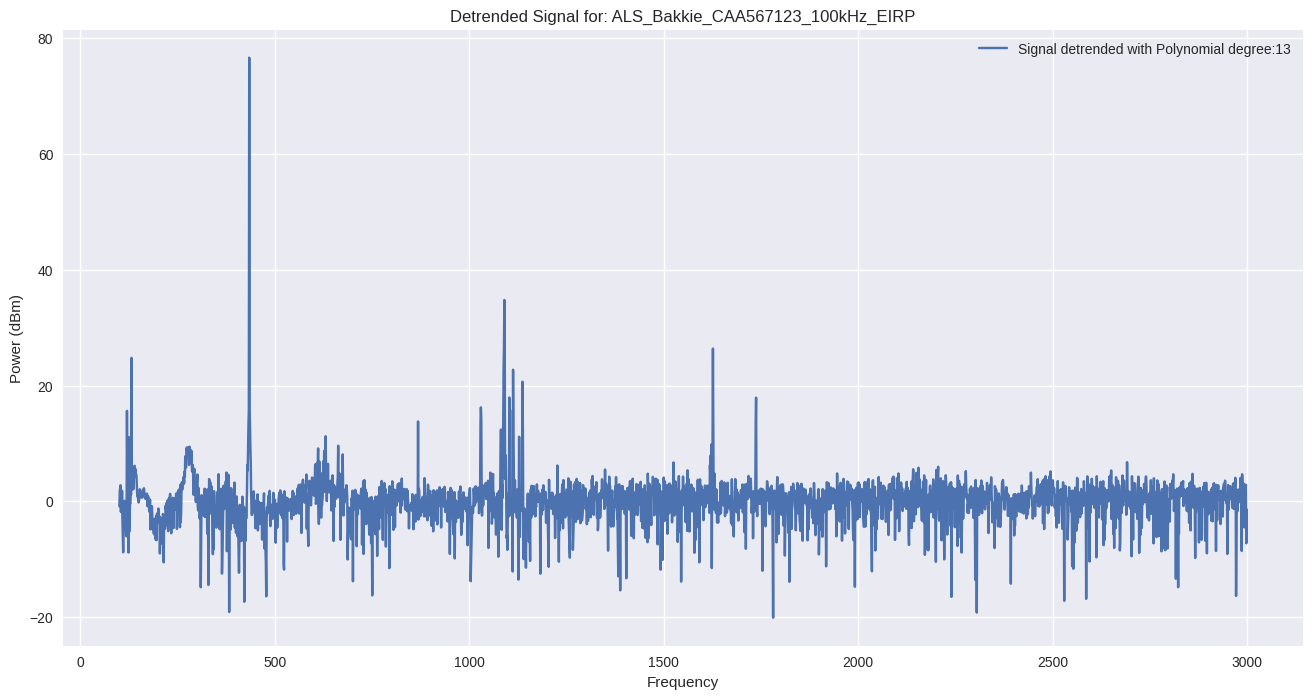

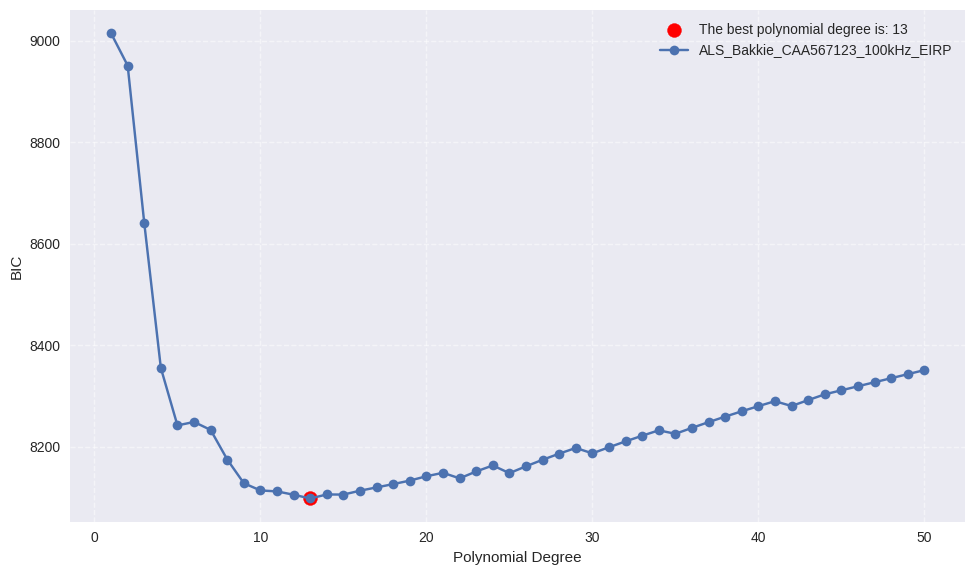

/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/860241756.py:4: RankWarning: Polyfit may be poorly conditioned
  bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)
/tmp/ipykernel_3935/86

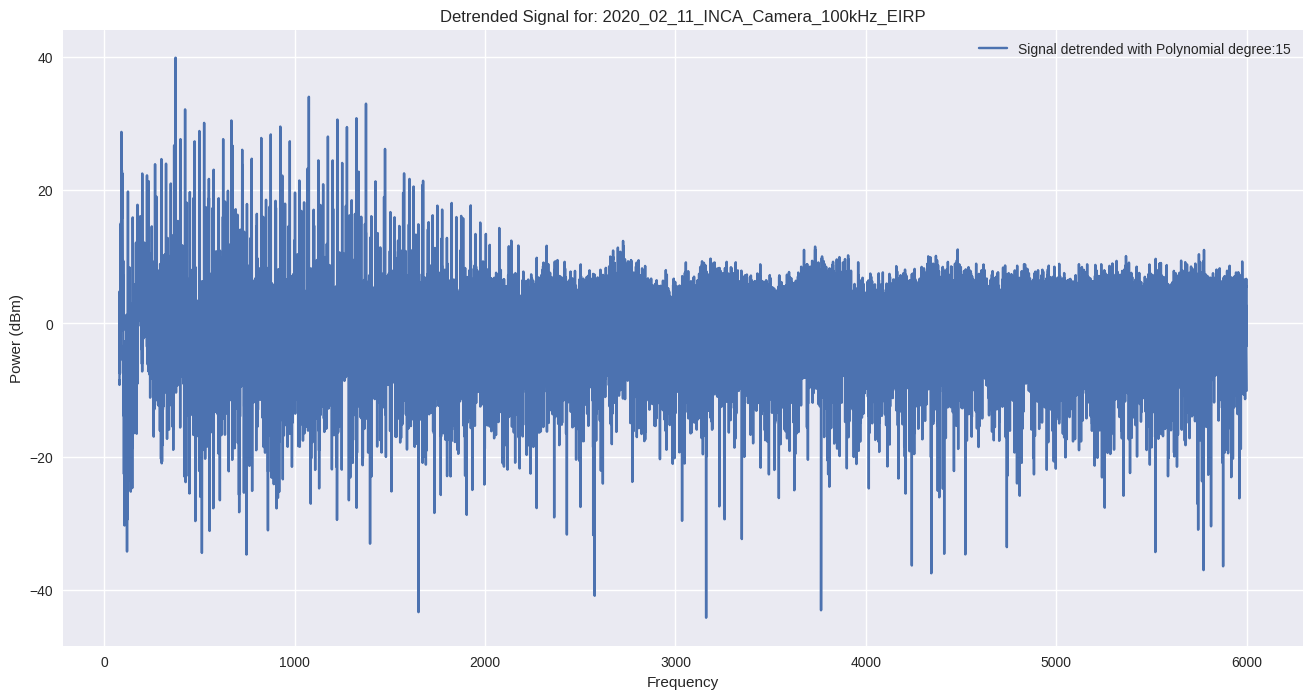

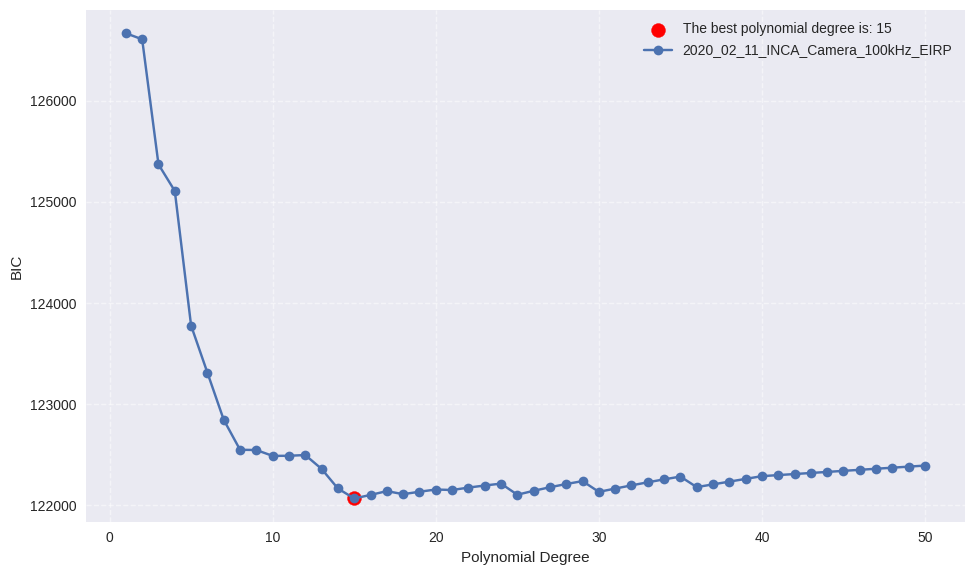

In [37]:
for instrument_name, df in dataframe_clean.items():

    # calculate the bic values
    bic, degree = calculate_bic(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], 50)

    # Find optimal degree
    optimal_idx = np.argmin(bic)
    optimal_degree = degree[optimal_idx]

    ## Perform Polynomial Detrending
    # determine the polynomial coeficients
    trend_pol = np.polyfit(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], degree[optimal_idx])
    # trend values 
    trend_values = np.polyval(trend_pol, df['Frequency (MHz)'])
    # detrend the signal 
    detrend_pol = df['Clean_EIRP(dBm)']-trend_values
    # print(f'The best polynomial degree is: {optimal_degree}')

    
    plt.style.use('seaborn')

    plt.figure(figsize=(16,8))
    plt.plot(df['Frequency (MHz)'], detrend_pol, label='Signal detrended with Polynomial degree:'+str(optimal_degree))
    plt.xlabel('Frequency')
    plt.ylabel('Power (dBm)')
    plt.title(f'Detrended Signal for: {instrument_name}')
    plt.legend()


    plt.figure(figsize=(10,6))
    plt.scatter(degree[optimal_idx], bic[optimal_idx], c='red', marker='o', s=100, label='The best polynomial degree is: '+str(optimal_degree))
    plt.plot(degree, bic, marker='o', label=instrument_name)
    plt.xlabel('Polynomial Degree')
    plt.ylabel('BIC')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


    

Create different notebook for each detrented method.

Diferente note book for each step.

In [38]:
#

# Define the best window legth for Savitzky-Golay filter.

In [39]:
def window_size(signal, windows):
    """
    Analyze different window lengths to use Savitzky-Golay filters.
    
    Parameters:
        signal (array): Signal values to analyze
        
    Returns:
        tuple: (trends, detrended_signals) containing all filtered results
    """
    # Configuration
    polyorder = 3
    
    # Calculate trends and detrended signals
    trends = []
    detrend_signal = []
    
    for w in windows:
        trend = savgol_filter(signal, window_length=w, polyorder=polyorder)
        det = signal - trend
        trends.append(trend)
        detrend_signal.append(det)
    

    return trends, detrend_signal

In [40]:
dataframe_clean

{'Kiricom_Radio_On_MAX_100kHz_EIRP':        Unnamed: 0  Frequency (MHz)  Clean_EIRP(dBm)
 0               0          80.0925       -59.478259
 1               1          80.1850       -61.157473
 2               2          80.2775       -61.318212
 3               3          80.3700       -60.994273
 4               4          80.4625       -61.422765
 ...           ...              ...              ...
 12797       21291        2049.5100       -87.196076
 12798       21292        2049.6025       -84.371832
 12799       21294        2049.7875       -86.330525
 12800       21295        2049.8800       -94.942077
 12801       21296        2049.9725       -92.431921
 
 [12802 rows x 3 columns],
 'Superfire_HL58_Headlamp_100kHz_EIRP':        Unnamed: 0  Frequency (MHz)  Clean_EIRP(dBm)
 0               1          80.0925      -105.448569
 1               2          80.1850      -129.491156
 2               5          80.4625       -98.770357
 3               6          80.5550       -93.65

/tmp/ipykernel_3935/3089742642.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


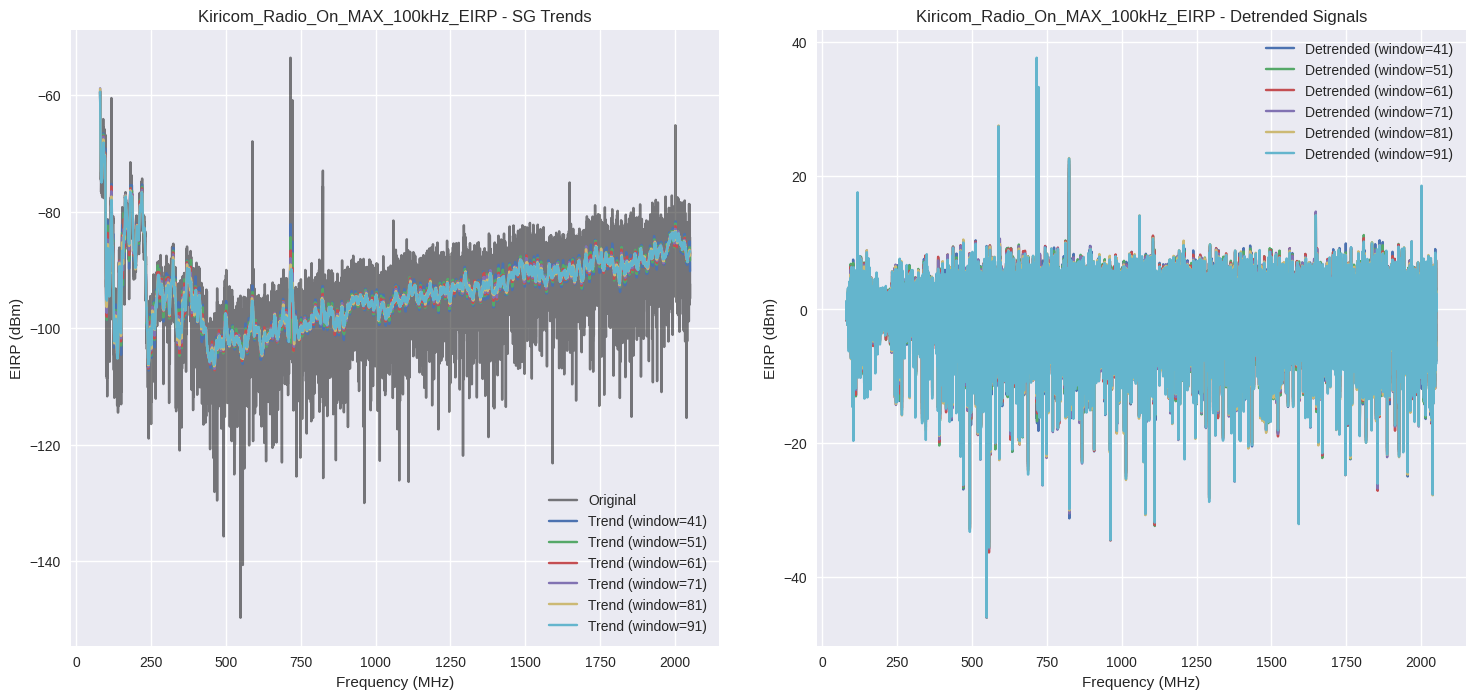

/tmp/ipykernel_3935/3089742642.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


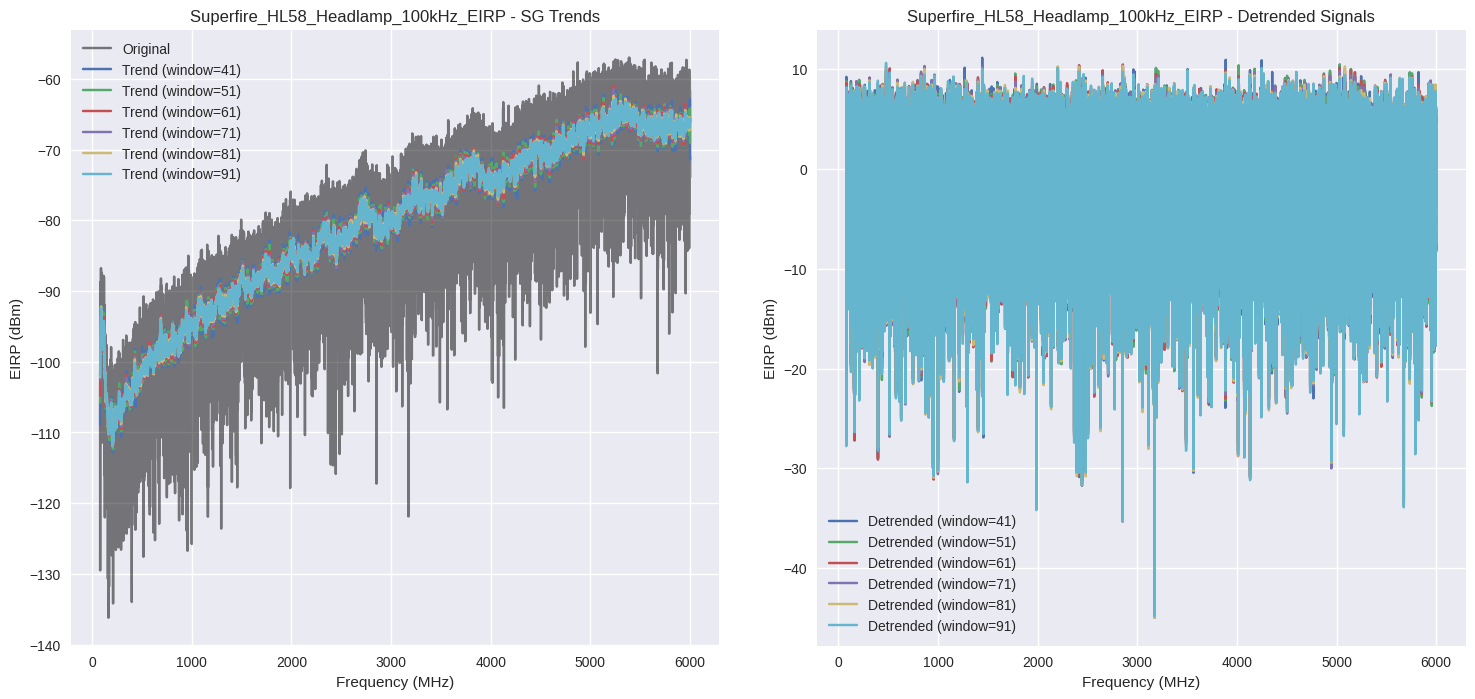

/tmp/ipykernel_3935/3089742642.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


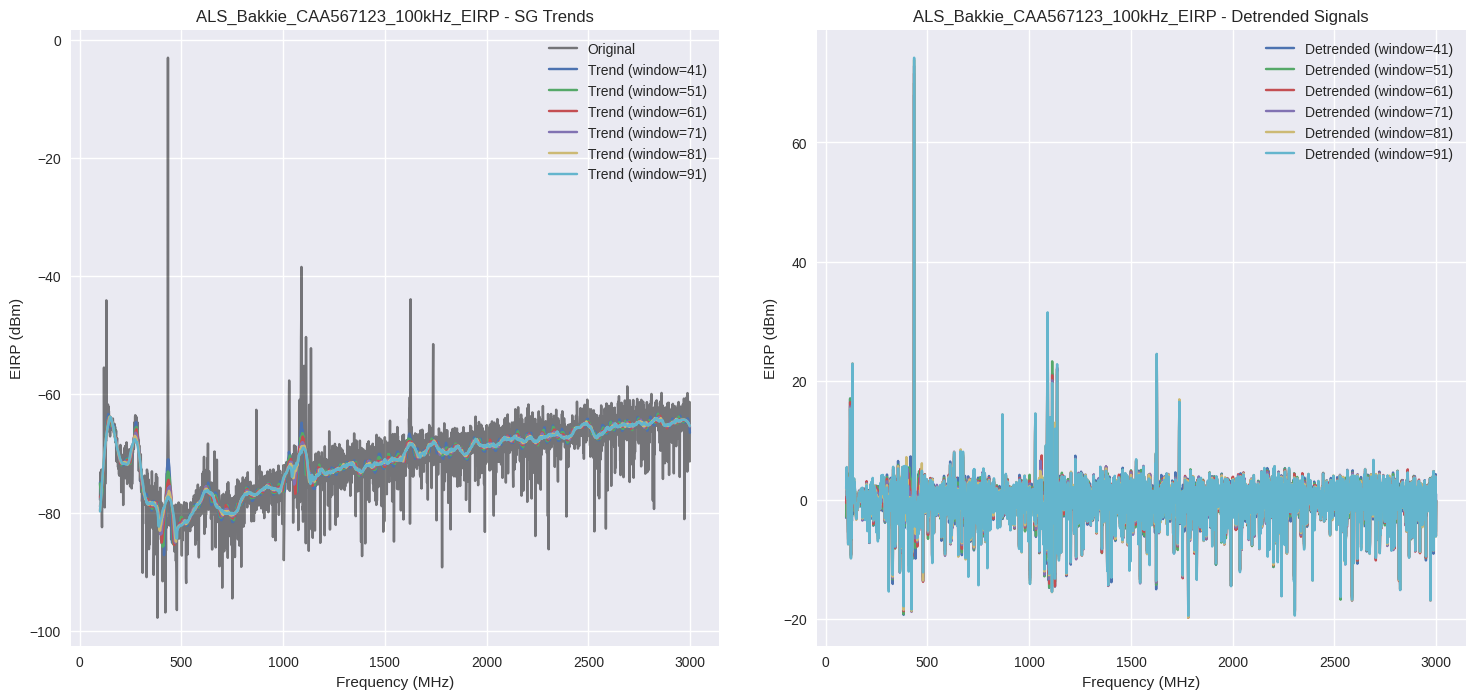

/tmp/ipykernel_3935/3089742642.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


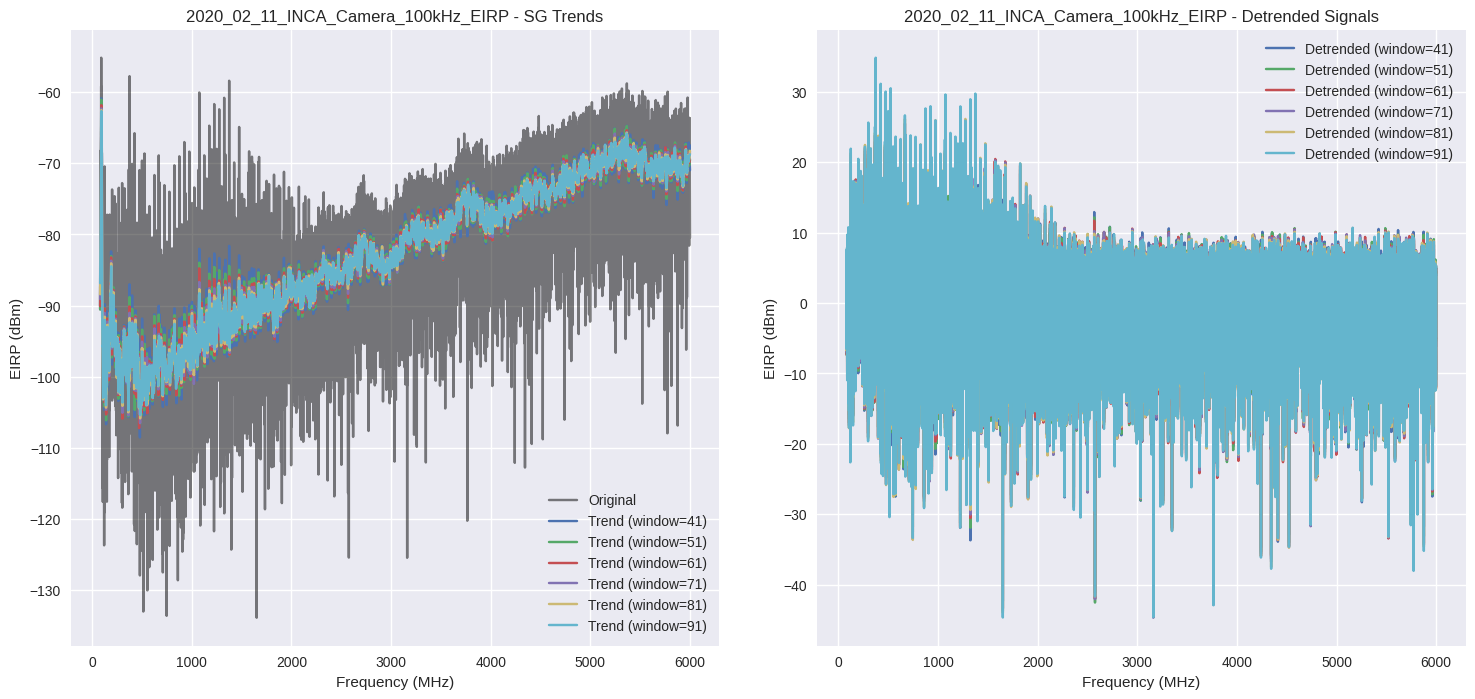

In [41]:
window_sizes = list(range(41,101,10))

for instrument_name, df in dataframe_clean.items():

    # Get the 2D arrays: one row per window size
    trend_sg, detrend_signal_sg = window_size(df['Clean_EIRP(dBm)'], windows=window_sizes)

    plt.style.use('seaborn')
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    fig.subplots_adjust(wspace=0.15)

    # Original signal
    axs[0].plot(df['Frequency (MHz)'], df['Clean_EIRP(dBm)'], color='black', alpha=0.5, label='Original')

    # Plot trends and detrended signals for each window size
    for i, w in enumerate(window_sizes):
        axs[0].plot(df['Frequency (MHz)'], trend_sg[i], label=f'Trend (window={w})')
        axs[1].plot(df['Frequency (MHz)'], detrend_signal_sg[i], label=f'Detrended (window={w})')

    axs[0].set_title(f"{instrument_name} - SG Trends")
    axs[1].set_title(f"{instrument_name} - Detrended Signals")
    axs[0].legend()
    axs[1].legend()
    axs[0].set_xlabel("Frequency (MHz)")
    axs[0].set_ylabel("EIRP (dBm)")
    axs[1].set_xlabel("Frequency (MHz)")
    axs[1].set_ylabel("EIRP (dBm)")
    plt.show()


In [42]:
def calculate_bic_sg(signal, window_sizes):
    """
    Calculate BIC values for different window lengths using the Savitzky-Golay filter.

    Parameters:
    - signal: array-like, signal values (e.g., EIRP)
    - max_window: int, maximum window length to test (must be odd)

    Returns:
    - bics_windows: list of BIC values for each window length
    - window_sizes: list of tested window sizes
    """
    
    #window_sizes = int(range(11, max_window, 10))  # Ensure variable name is consistent
    bics_windows = []
    
    n = len(signal)

    for w in window_sizes:
     
        # Apply SG filter
        trend_sg = savgol_filter(signal, window_length=w, polyorder=3)

        # Residual sum of squares
        residuals = signal - trend_sg
        rss = np.sum(residuals ** 2)

        # BIC calculation
        k = w + 1 # Model complexity proxy: window length
        bic = n * np.log(rss / n) + k * np.log(n)

        bics_windows.append(bic)

    return bics_windows, window_sizes 


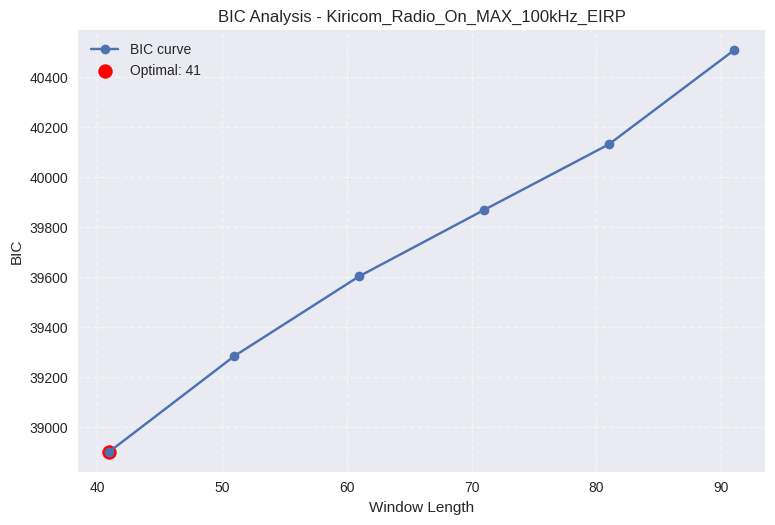

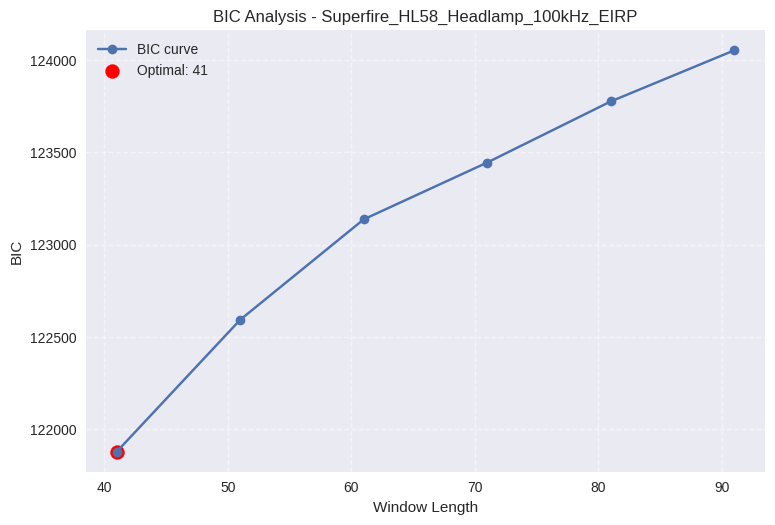

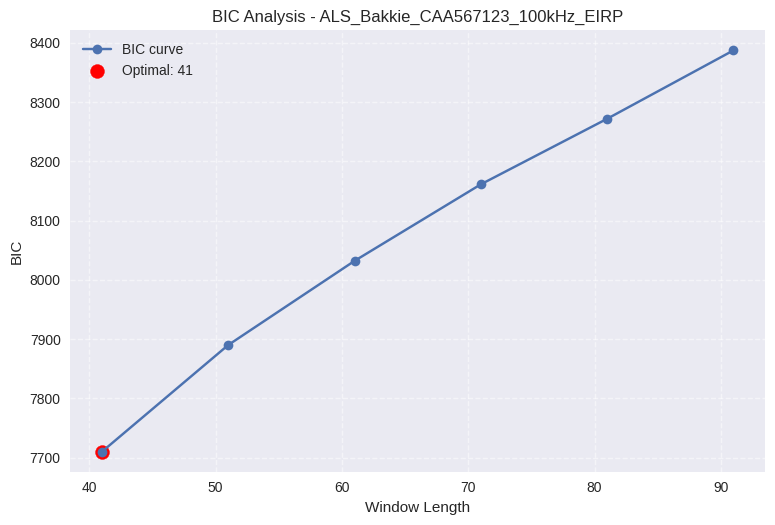

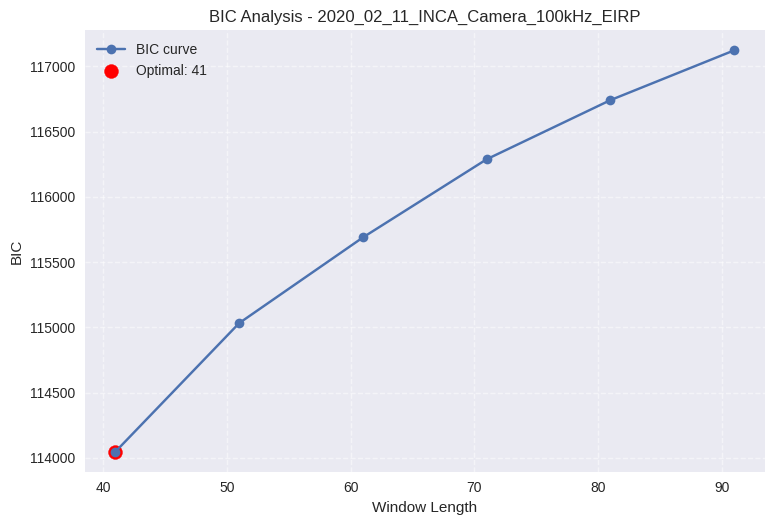

In [43]:
for instrument_name, df in dataframe_clean.items():
    signal = df['Clean_EIRP(dBm)']

    # Step 1: Calculate BIC for all window sizes
    bic_w, wind_s = calculate_bic_sg(signal, window_sizes)

    # Step 2: Find the optimal window size (min BIC)
    optimal_idx = np.argmin(bic_w)
    optimal_window = wind_s[optimal_idx]

    # Step 3: Apply SG filter using optimal window
    trend = savgol_filter(signal, polyorder=3, window_length=optimal_window)
    detrend = signal - trend

    # Step 4: Plot BIC curve
    plt.plot(wind_s, bic_w, marker='o', label='BIC curve')
    plt.scatter(optimal_window, bic_w[optimal_idx], color='red', s=100, label=f'Optimal: {optimal_window}')
    plt.xlabel('Window Length')
    plt.ylabel('BIC')
    plt.title(f'BIC Analysis - {instrument_name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


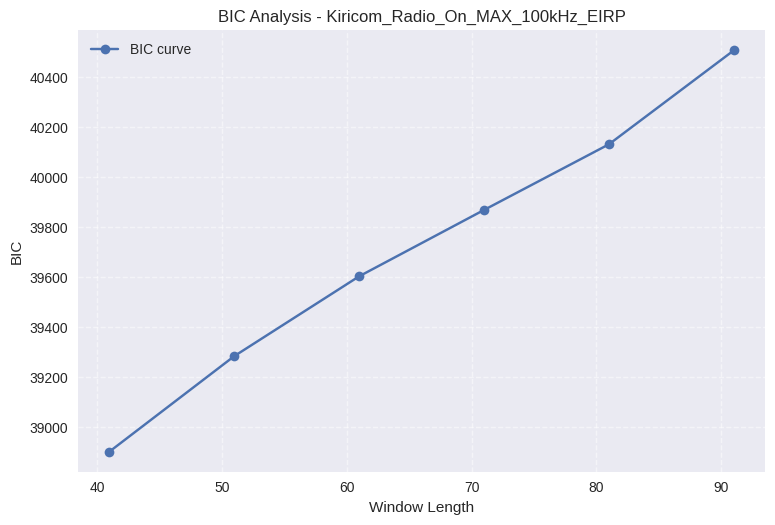

In [44]:
for instrument_name, df in dataframe_clean.items():

    # Calculate the Bic for all window
    bic_w, wind_s = calculate_bic_sg(df['Clean_EIRP(dBm)'], window_sizes)

    # Step 4: Identify optimal window length
    optimal_idx = np.argmin(bic_w)
    optimal_window = wind_s[optimal_idx]


    # Appy the filter with the optimal window
    trend = savgol_filter(df['Clean_EIRP(dBm)'],polyorder=3, window_length=optimal_window)
    detren = df['Clean_EIRP(dBm)']- trend

    
    # Calculate the Bic for all window
    bic_w, wind_s = calculate_bic_sg(df['Clean_EIRP(dBm)'], window_sizes)

    # Step 4: Identify optimal window length
    optimal_idx = np.argmin(bic_w)
    optimal_window = wind_s[optimal_idx]


    # Appy the filter with the optimal window
    trend = savgol_filter(df['Clean_EIRP(dBm)'],polyorder=3, window_length=optimal_window)
    detren = df['Clean_EIRP(dBm)']- trend



        
    plt.plot(wind_s, bic_w, marker='o', label='BIC curve')
    #plt.scatter(wind_s[optimal_idx], bic_w[optimal_idx], c='red', marker='o', s=100, label='The best window lenth is: '+str(optimal_window))
    plt.xlabel('Window Length')
    plt.ylabel('BIC')
    plt.title(f'BIC Analysis - {instrument_name}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    break

        
        # plt.plot(wind_s, bic_w, marker='o', label='BIC curve')
        # #plt.scatter(wind_s[optimal_idx], bic_w[optimal_idx], c='red', marker='o', s=100, label='The best window lenth is: '+str(optimal_window))
        # plt.xlabel('Window Length')
        # plt.ylabel('BIC')
        # plt.title(f'BIC Analysis - {instrument_name}')
        # plt.legend()
        # plt.grid(True, linestyle='--', alpha=0.5)
        # plt.tight_layout()
        # plt.show()

        # break

In [45]:
window_sizes

[41, 51, 61, 71, 81, 91]

Optimal window length: 41


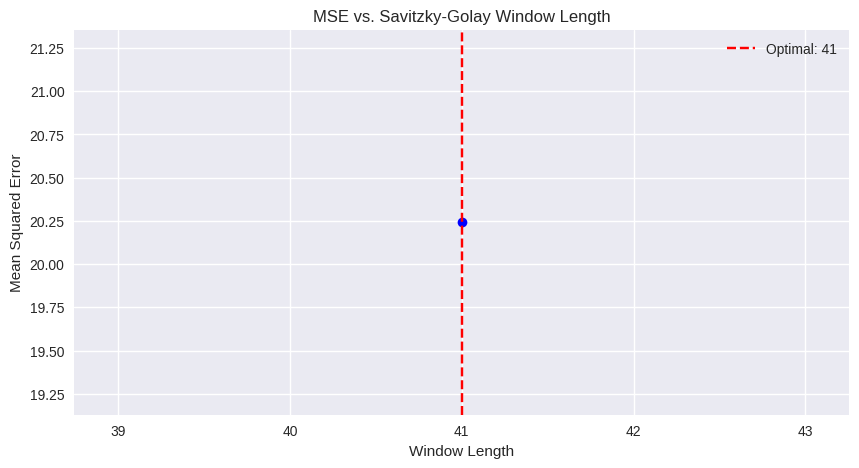

Optimal window length: 41


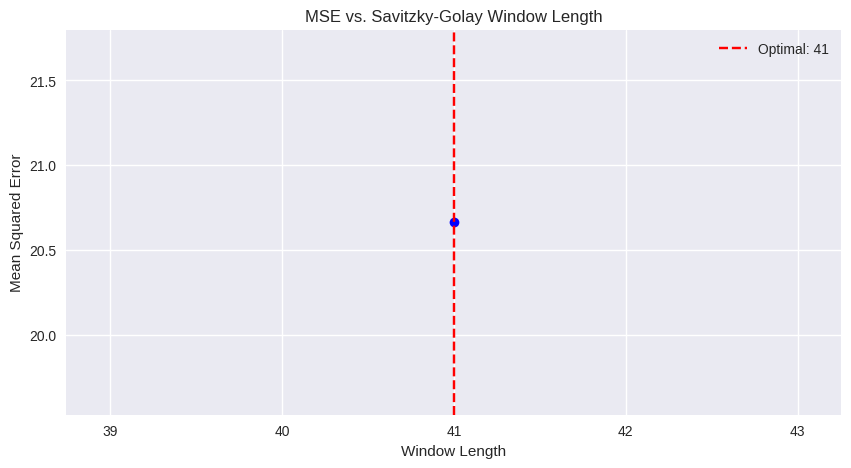

Optimal window length: 41


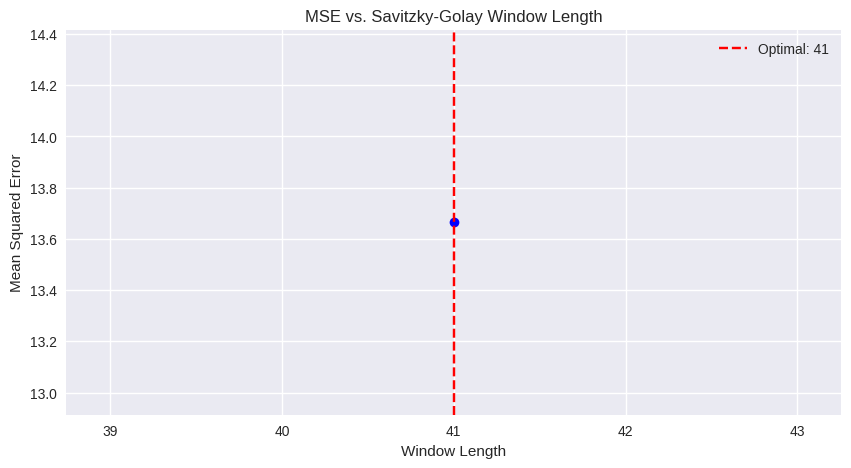

Optimal window length: 41


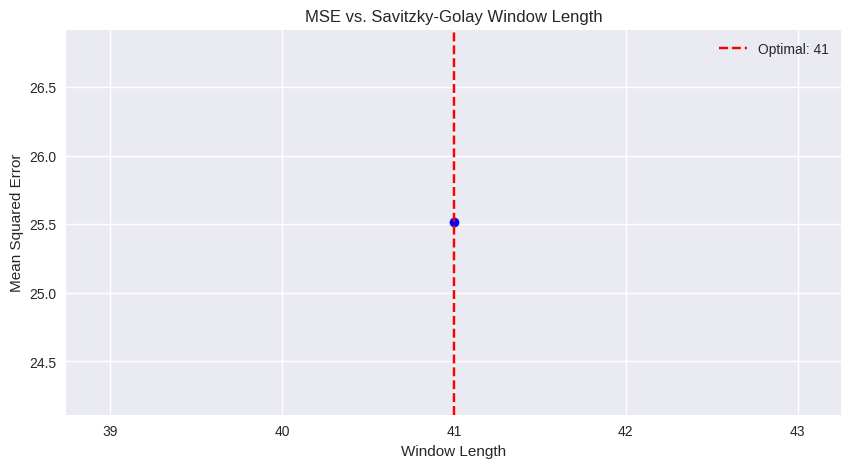

In [46]:

def find_optimal_window(signal, window_range, polyorder=3):
    """
    Find the optimal window length for Savitzky-Golay filter using MSE minimization
    
    Parameters:
    signal (array): Input signal
    window_range (range/list): Range of window sizes to test (must be odd integers)
    polyorder (int): Polynomial order for SG filter
    
    Returns:
    best_window (int): Optimal window length
    mse_values (list): MSE for each window size
    """
    mse_values = []
    
    for w in window_range:
        try:
            # Apply SG filter
            filtered = savgol_filter(signal, window_length=w, polyorder=polyorder)
            
            # Calculate MSE between original and filtered signal
            mse = mean_squared_error(signal, filtered)
            mse_values.append(mse)
            
        except ValueError:
            # Skip invalid window sizes
            mse_values.append(np.inf)
    
    # Find window with minimum MSE
    best_idx = np.argmin(mse_values)
    best_window = window_range[best_idx]
    
    return best_window, mse_values

for instrument_name, df in dataframe_clean.items():


    signal = df['Clean_EIRP(dBm)']  # Replace with your signal
    window_range = range(41, 101, 210)  # Odd numbers from 5 to 49

    best_window, mse_values = find_optimal_window(signal, window_range)

    print(f"Optimal window length: {best_window}")

    plt.figure(figsize=(10, 5))
    plt.plot(window_range, mse_values, 'bo-')
    plt.xlabel('Window Length')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE vs. Savitzky-Golay Window Length')
    plt.axvline(best_window, color='r', linestyle='--', 
            label=f'Optimal: {best_window}')
    plt.grid(True)
    plt.legend()
    plt.show()

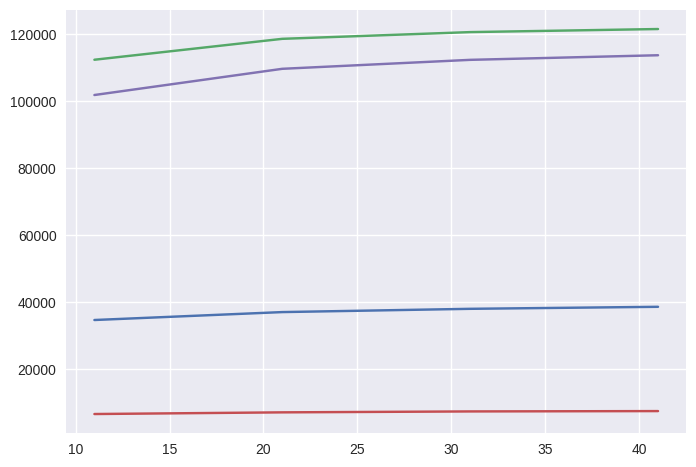

In [47]:

def calculate_bic(signal, window_length, polyorder=3):
    trend = savgol_filter(signal, window_length, polyorder)
    residuals = signal - trend
    n = len(signal)
    rss = np.sum(residuals**2)
    k = polyorder + 1  # Number of parameters (polynomial coefficients + window size)
    bic = n * np.log(rss/n) + k * np.log(n)  # BIC formula
    return bic

for instrument_name, df in dataframe_clean.items():


    # Test window sizes (must be odd)
    window_sizes = range(11, 51, 10)  
    bic_scores = [calculate_bic(df['Clean_EIRP(dBm)'], w) for w in window_sizes]
    optimal_window = window_sizes[np.argmin(bic_scores)]


    plt.plot(window_sizes,bic_scores)